#Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.draw import ellipse
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Phantom Generation and Helper Fucntion

In [2]:
# Helper Function
def generate_ellipse_phantom(num_ellipses=1,
                             height=28, width=28):
    """
    Creates a 28x28 image (phantom) with the specified number of ellipses.
    The image is returned as a 2D numpy array in the range [0,1].
    """
    img = np.zeros((height, width), dtype=np.float32)

    for _ in range(num_ellipses):
        # Random center, ensuring ellipses are fully within the 28x28
        center_x = np.random.randint(5, height-5)
        center_y = np.random.randint(5, width-5)

        # Random ellipse "radii"
        rx = np.random.randint(3, 7)
        ry = np.random.randint(3, 7)

        # Draw a filled ellipse
        rr, cc = ellipse(center_x, center_y, rx, ry, shape=img.shape)
        # Add 1.0 to those pixels (clip to 1 so it stays bright)
        img[rr, cc] = 1.0

    return img

In [3]:
def generate_dataset(num_samples=2000, height=28, width=28):
    """
    Returns images and labels.
    - images: numpy array of shape (num_samples, height, width)
    - labels: 0 if the image has 1 ellipse, 1 if the image has 2 ellipses
    """
    images = []
    labels = []
    half = num_samples // 2

    for _ in range(half):
        # Class 0: One ellipse
        img = generate_ellipse_phantom(num_ellipses=1,
                                       height=height, width=width)
        images.append(img)
        labels.append(0)

    for _ in range(num_samples - half):
        # Class 1: Two ellipses
        img = generate_ellipse_phantom(num_ellipses=2,
                                       height=height, width=width)
        images.append(img)
        labels.append(1)

    images = np.array(images)
    labels = np.array(labels)
    return images, labels

#Create and Inspect The Data Set

Dataset shape: (2000, 28, 28)
Labels shape: (2000,)


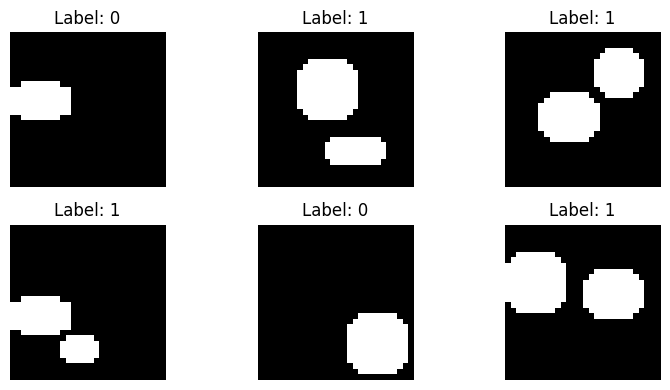

In [4]:
# Generate a dataset of 2,000 total samples (1,000 with 1 ellipse, 1,000 with 2)
X, y = generate_dataset(num_samples=2000)
print("Dataset shape:", X.shape)
print("Labels shape:", y.shape)

# Let’s shuffle the dataset so 1-ellipse and 2-ellipses are mixed
perm = np.random.permutation(len(X))
X = X[perm]
y = y[perm]

# Show a few random images
plt.figure(figsize=(8,4))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X[i], cmap='gray')
    plt.title(f"Label: {y[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#Split Into Test/Train and Prepare The Tensors

In [5]:
# Simple 80/20 split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Keras CNNs generally expect 4D input: (batch, height, width, channels)
# Currently X_train/X_test are (N, 28, 28). We add a channel dimension:
X_train = X_train[..., np.newaxis]
X_test  = X_test[..., np.newaxis]

# Convert labels to one-hot if you like, or just use sparse crossentropy.
# Here we will just use them as integer classes 0/1.
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (1600, 28, 28, 1)
y_train shape: (1600,)


#Build a Simple Neural Network

In [6]:
model = keras.Sequential([
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',
                  input_shape=(28,28,1)),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2,2)),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # output=1 for binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 800)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,129 (219.25 KB)

 Trainable params: 56,129 (219.25 KB)

 Non-trainable params: 0 (0.00 B)

#Train the Model

In [8]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.2)  # e.g. 20% of training data as validation

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8696 - loss: 0.2758 - val_accuracy: 0.8781 - val_loss: 0.3088
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8991 - loss: 0.2433 - val_accuracy: 0.9031 - val_loss: 0.2449
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.8989 - loss: 0.2218 - val_accuracy: 0.8938 - val_loss: 0.2657
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8985 - loss: 0.2431 - val_accuracy: 0.8906 - val_loss: 0.2519
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9141 - loss: 0.1982 - val_accuracy: 0.9000 - val_loss: 0.2431
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9026 - loss: 0.2205 - val_accuracy: 0.9156 - val_loss: 0.2298
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9306 - loss: 0.1865 - val_accuracy: 0.9031 - val_loss: 0.2299
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9170 - loss: 0.1915 - val_accuracy: 0.8938 - v

#Evaluate on the Test Set

In [9]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

Test loss: 0.28960564732551575
Test accuracy: 0.9200000166893005


#Visualize Some Predictions

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


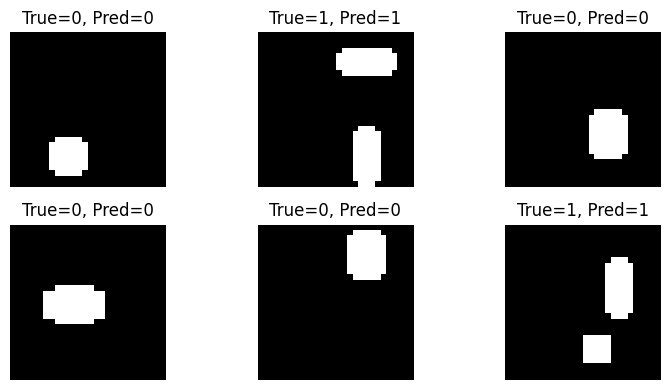

In [10]:
predictions = model.predict(X_test)
predictions = (predictions > 0.5).astype(int).flatten()

plt.figure(figsize=(8,4))
for i in range(6):
    idx = np.random.randint(0, len(X_test))
    plt.subplot(2,3,i+1)
    plt.imshow(X_test[idx].squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"True={y_test[idx]}, Pred={predictions[idx]}")
plt.tight_layout()
plt.show()